In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import datetime
import random
from decimal import Decimal

from scipy.stats import pearsonr
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

import time

# Data Dictionary

- **Index**: Time Series over 2019
- **day_of_week**: 0 = Monday, 6 = Sunday
- **updated_orders**: number of orders
- **marketing_expense_no_noise**: marketing expense over time, following the distribution of "updated orders" with a window shift
- **product_i_quantity**: number of products of type i sold every day
- **nb_quantity_sold**: total number of products sold every day (sum of all **product_i_quantity**)
- **product_i_revenue**: Total revenue brought by one product each day
- **total_revenue**: Total revenue brought by all products (sum of all **product_i_revenue**)

# Objective

Generate fake data of daily sales/orders, for different retailers selling similar products, with <b>stories</b> that explain variations in the number of sales (eg day of the week, holiday period, marketing expenses etc).
<br><br><br>
First I create fake data, with X sales every day of the year. 
<br>
Then I add noise and constraints, so that the daily sales follow a trend that is dependent on several factors (see stories below).
<br><br><br>
This fake data makes it possible:
<br>
1/ with Time Series to predict the number of sales in the future
<br>
2/ to try to <b>explain</b> the variation in sales with the stories

# Stories:

## <i>In order to explain variations, each story is in the format <b>IF</b> something happens, <b>THEN</b> impact on the sales</i>

#### Story 1: 

**IF** sales during holiday seasons (Christmas, Summer, Valentine's Day) **THEN** higher number of orders

#### Story 2: 

**IF** sales during middle of the week **THEN** more higher number of orders

#### Story 3: 

**IF** High marketing spending **THEN** higher number of orders

**Story 4**: 

**IF** day = *Tuesday* **AND** season = *Spring* **AND** Marketing Spending = *LOW* (1st quartile)

**THEN** Number of Orders = 25% more the next day

#### Story 5: 

**IF** high number of products sold, **THEN** high number of orders

**Story 6**:

**IF** Marketing expense = *High* (Highest 20%) **AND** product_1 sells more than product_3 
**THEN** Number of Orders = 25% Higher

**Story 7:**

**IF** we put a lower price to a product, **THEN** we sell more orders of this product

# Create number of orders column

### Table initialization

We create the basis of our table: a Date Index over one year, and a Number of Orders column

In [2]:
def initialize_table():
    """
    Initialize a 1-year empty table
    """
    date = pd.to_datetime("1st of January, 2019") + pd.to_timedelta(np.arange(365), 'D')
    nb_orders = np.zeros(date.shape)

    data = pd.DataFrame({'date': date,
                  'nb_orders': nb_orders
                 }).set_index('date')
    return data

### Assign datapoints

We create the basis of our table: a <b>Date Index</b> over one year, and a <b>Number of Orders</b> column

In [3]:
import datetime
import random

def choose_random_date_around_initial_date(date_center, offset_before_date_center, offset_after_date_center):
    """
    Given a date, the function returns a random date centered around the former
    """
    date_start = pd.to_datetime(date_center) - pd.DateOffset(offset_before_date_center)
    date_end = pd.to_datetime(date_center) + pd.DateOffset(offset_after_date_center)

    random_number_of_days = random.randrange((date_end - date_start).days)
    random_date = date_start + datetime.timedelta(days=random_number_of_days)

    return random_date

Below I determine specific <b> major data points</b> with an arbitrary number of sales

In [4]:
from decimal import Decimal

def assign_datapoints(data, nb_orders_jan1):
    # Assigning time datapoints

    DATAPOINT_JAN_1 = nb_orders_jan1
    date_jan_1 = '2019-01-01'

    # nb_orders centered around 0.5 + date centered around feb_1
    DATAPOINT_FEB_1 = DATAPOINT_JAN_1 * np.random.uniform(0.4, 0.6)
    date_feb_1_init = '2019-02-01'
    date_feb_1 = choose_random_date_around_initial_date(date_feb_1_init, 7, 8)

    # Centered around 1.5
    DATAPOINT_FEB_15 = DATAPOINT_JAN_1 * np.random.uniform(1.4, 1.6)
    date_feb_15_init = '2019-02-15'
    date_feb_15 = choose_random_date_around_initial_date(date_feb_15_init, 7, 8)

    # Centered around 0.5
    DATAPOINT_MAR_1 = DATAPOINT_JAN_1 * np.random.uniform(0.4, 0.6)
    date_mar_1_init = '2019-03-01'
    date_mar_1 = choose_random_date_around_initial_date(date_mar_1_init, 7, 8)

    # Centered around 0.5
    DATAPOINT_MAY_1 = DATAPOINT_JAN_1 * np.random.uniform(0.4, 0.6)
    date_may_1_init = '2019-05-01'
    date_may_1 = choose_random_date_around_initial_date(date_may_1_init, 7, 8)

    # Centered around 0.8
    DATAPOINT_JUL_1 = DATAPOINT_JAN_1 * np.random.uniform(0.7, 0.9)
    date_jul_1_init = '2019-07-01'
    date_jul_1 = choose_random_date_around_initial_date(date_jul_1_init, 7, 8)

    # Centered around 1.5
    DATAPOINT_AUG_1 = DATAPOINT_JAN_1 * np.random.uniform(1.4, 1.6)
    date_aug_1_init = '2019-08-01'
    date_aug_1 = choose_random_date_around_initial_date(date_aug_1_init, 7, 8)

    # Centered around 0.5
    DATAPOINT_OCT_1 = DATAPOINT_JAN_1 * np.random.uniform(0.4, 0.6)
    date_oct_1_init = '2019-10-01'
    date_oct_1 = choose_random_date_around_initial_date(date_oct_1_init, 7, 8)

    # Centered around 0.8
    DATAPOINT_DEC_1 = DATAPOINT_JAN_1 * np.random.uniform(0.7, 0.9)
    date_dec_1_init = '2019-12-01'
    date_dec_1 = choose_random_date_around_initial_date(date_dec_1_init, 7, 8)

    # Centered around 0.5
    DATAPOINT_DEC_25 = DATAPOINT_JAN_1 * np.random.uniform(1.9, 2.1)
    date_dec_25_init = '2019-12-25'
    date_dec_25 = choose_random_date_around_initial_date(date_dec_25_init, 7, 8)

    DATAPOINT_DEC_31 = DATAPOINT_JAN_1 * np.random.uniform(0.9, 1.1)
    date_dec_31 = '2019-12-31'

    dates_to_assign = [date_jan_1, date_feb_1, date_feb_15, date_mar_1, date_may_1, date_jul_1,
                      date_aug_1, date_oct_1, date_dec_1, date_dec_25, date_dec_31]

    date_nb_orders_to_date = {date_jan_1: DATAPOINT_JAN_1,
                      date_feb_1: DATAPOINT_FEB_1,
                      date_feb_15: DATAPOINT_FEB_15,
                      date_mar_1: DATAPOINT_MAR_1,
                      date_may_1: DATAPOINT_MAY_1,
                      date_jul_1: DATAPOINT_JUL_1,
                      date_aug_1: DATAPOINT_AUG_1,
                      date_oct_1: DATAPOINT_OCT_1,
                      date_dec_1: DATAPOINT_DEC_1,
                      date_dec_25: DATAPOINT_DEC_25,
                      date_dec_31: DATAPOINT_DEC_31
                     }


    # Assigning the values above to the dates
    for k, v in date_nb_orders_to_date.items():
        data.loc[k, 'nb_orders'] = v
    return data, dates_to_assign, date_nb_orders_to_date

### Fill column "number of orders" for each day of the year

Creating functions to fill the rest of the year with data, to join each of the determined data points with </b>number of orders </b> that linearly evolves between each data point

In [5]:
from decimal import Decimal

def lin_equ(l1, l2):
    """
    Given two datapoints l1 and l2 with their x and y coordinates (x = day of the year, y = Number of orders),
    the function returns the linear coefficient and intercept of the line between these two datapoints
    """
    coef = float(Decimal((l2[1] - l1[1])) / Decimal(l2[0] - l1[0]))
    intercept = float((l1[1] - (coef * l1[0])))
    return coef, intercept


def value_equ(l1, l2, x):
    """
    Given a coefficient and an intercept, this function returns the linear result
    """
    coef, intercept = lin_equ(l1, l2)
    return coef * x + intercept


def fill_date_linear(data, date_nb_orders_to_date, first_date, second_date):
    """
    Given two dates, the function fills the table with linear result between these two dates
    """
    for i in pd.date_range(pd.to_datetime(first_date) + pd.DateOffset(1), second_date):
        data.loc[i, 'nb_orders'] = np.round(value_equ((0, date_nb_orders_to_date[first_date]),
                                             ((pd.to_datetime(second_date) - pd.to_datetime(first_date)).days, date_nb_orders_to_date[second_date]),
                                             (pd.to_datetime(i) - pd.to_datetime(first_date)).days))

        
def add_noise(data, dates_to_assign, col, mu, sigma):
    """
    Given a df, a column name, and normal distribution parameters, 
    the function adds noise to the column data
    """
    for i in pd.date_range(pd.to_datetime(dates_to_assign[0]), dates_to_assign[-1]):
        data.loc[i, col] = np.round(data.loc[i, col] + np.random.normal(mu, sigma))


def fill_table(data, date_nb_orders_to_date, dates_to_assign):
    for i, date in enumerate(dates_to_assign[:-1]):
        fill_date_linear(data, date_nb_orders_to_date, date, dates_to_assign[i + 1])
    fill_date_linear(data, date_nb_orders_to_date, dates_to_assign[-2], dates_to_assign[-1])

### Add week periodicity

Updating orders with <b>weekly periodicity</b>: I arbitrarily determine the percentage trend depending on the day of the week

In [6]:
def add_day_of_week(data):
    data['day_of_week'] = data.index.dayofweek
    return data

def add_weekly_periodicity(data, coeffs):
    """
    Add periodicity on week with specific coefficients for the week
    """
    # Creating weekly periodicity coefficients
    pct_added_orders_day_of_week = coeffs

    period_day_of_week = dict(zip([i for i in range(7)], pct_added_orders_day_of_week))

    # Updating data with the weekly periodicity
    data['updated_orders'] = np.round(data['day_of_week'].map(period_day_of_week) * data['nb_orders'])
    data.drop(columns=["nb_orders"], inplace=True)
    return data

# Add marketing expense

We add a marketing_expense feature that is highly correlated to the number of orders,

We shift data of marketing expense a few days earlier,

And we remove noise of marketing expense

In [7]:
from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.signal import lfilter


def remove_noise_marketing_expense(data, n, a):
    """
    Smoother curve of marketing expense
    """
    n = 15
    b = [1.0 / n] * n
    a = 1
    t = data.index
    yy = lfilter(b, a, data['Marketing_expense_no_noise'])
    data['Marketing_expense_no_noise'] = lfilter(b, a, data['Marketing_expense_no_noise'])
    return data


def add_marketing_expense(data, shift_period):
    """
    Add column marketing expense that is correlated to number of orders column, with a shift
    """
    data['Marketing_expense'] = minimize(lambda x: abs(0.8 - pearsonr(data['updated_orders'], x)[0]), 
                                 np.random.rand(len(data['updated_orders']))).x

    data['Marketing_expense_no_noise'] = data['Marketing_expense'].shift(periods=-shift_period)
    data.drop(columns=['Marketing_expense'], inplace=True)
    return data

# Modifying data to fit a story based on day of week, date, marketing expense maximum

We first get the index of the table that match the criteria of the story (low marketing expense on day X, day of the week is Y and date is in specific time range - in this example spring),

And we update the next day with x% more sales

In [8]:
def add_story_4(data, day_of_week, lim_inf, lim_sup, quantile, increase_percentage_next_day):
    """
    day_of_week: number between 0 and 6, 0 being Monday and 6 Sunday
    lim_inf: date max to which function applies
    lim_sup: date min to which function applies
    quantile: percentile of Marketing Expense to which function applies
    increase_percentage_next_day: percentage of sales to apply to the next day 
                                  Vs day that matches previous conditions
    """
    # We get the index of rows that match our criteria
    ind_days_story = np.where((data['day_of_week'] == day_of_week) 
             & ((data.index < lim_inf) | (data.index > lim_sup)) 
             & (data['Marketing_expense_no_noise'] < data['Marketing_expense_no_noise'].quantile(q=quantile)))[0]

    # We update the table: the sales on next day are superior by 'increase_percentage_next_day'%
    data['updated_orders'][ind_days_story + 1] = list(
        round(data.iloc[ind_days_story, :].loc[:, 'updated_orders'] * (1 + increase_percentage_next_day)) )
    return data

# Add different products quantities

We first generate quantity for each product, then we sum all quantities.

We create NB_SAMPLES different products, with a random correlation between the sales of this product and the feature **nb of orders**.

In the example below, I choose **4 products**, and correlation between 0.3 and 0.9 --> possible to consider a higher MIN_CORR number

In order to have real quantity numbers, I apply **x100** to the quantity of each **product_i_quantity column**, get the max value between 0 and current value to mkae sure I don't have negative values.

Then I add some noise

In [9]:
def add_products(data, nb_samples, correlation_products_coeffs, mu_noise, sigma_noise):
    """
    Add different products with various correlation to number of orders

    nb_samples: number of different products
    min_corr: minimum correlation between products sales and total number of orders
    max_corr: maximum correlation between products sales and total number of orders
    mu_noise & sigma_noise: noise to add to product quantities
    """

    # Create products quantities
    for i in range(nb_samples):
        data[f'product_{i+1}_quantity'] = minimize(lambda x: abs(correlation_products_coeffs[i] 
                                                      - pearsonr(data['updated_orders'], x)[0]), 
                                 np.random.rand(len(data['updated_orders']))).x
    
    # Add noise and round
    for i in range(nb_samples):
        data[f'product_{i+1}_quantity'] = np.maximum(np.round((data[f'product_{i+1}_quantity'] * 100)
                                                      + np.random.normal(mu_noise, sigma_noise)), 0)
        
    return data

I create the column **nb_quantity_sold** that corresponds to the sum of all **product_i_quantity columns**

In [10]:
def add_total_quantity(data):
    """
    Sum quantities of all different products
    """
    temp_data = data.loc[:, data.columns.str.startswith("product_")]
    data['nb_quantity_sold'] = temp_data.sum(axis=1)
    return data

# Modify data to fit a story based on marketing expense and number of products sold for Product 1 Vs Product 3 

In [11]:
def add_story_6(data, q, product_1, product_2, increase_percentage):
    """
    Function to modify column "nb of order" on specific days, 
    so that we have a higher number of orders under certain conditions:
      - marketing expense over a certain level
      - number of sales of a product is superior to number of sales of another product
      
    q: quantile of marketing expense we choose, to filter to data where marketing expense is above this quantile
    product_1 / product_2: choosing the products we want to compare and filter as part of the story
    increase_percentage: difference of percentage between low price and high price for a same product
    """
    ind_story = np.where((data['Marketing_expense_no_noise'] > data['Marketing_expense_no_noise'].quantile(q)) &
             (data[product_1] < data[product_2]))[0]
    data['updated_orders'][ind_story] = data['updated_orders'][ind_story] * (1 + increase_percentage)
    return data

# Adding price variation of each product: a low price among 2 possible prices involves a higher number of sales of this same product

In [12]:
from sklearn.preprocessing import MinMaxScaler

def add_product_revenue(data, nb_samples, prices, increase_pct):
    """
    Calculate revenue of each product each day, based on quantity and price.
    The function calculates the price per unit sold each day, between 2 choices:
    if product quantity sold is high, then probability that product was sold at low price is higher
    
    increase_pct: percentage difference between low and high price
    """
    # Normalize quantities of products sold to get array of probabilities
    scaler = MinMaxScaler()
    scaled_features = np.round(scaler.fit_transform(data.loc[:, [f'product_{i+1}_quantity' for i in range(nb_samples)]].values), 
                               decimals=2)

    products_proba = pd.DataFrame(scaled_features, 
                                  index=data.index, 
                                  columns=[f'product_{i+1}_normed' for i in range(nb_samples)])
    
    # Calculate revenue:
    for i in range(nb_samples):
        # We take each different product
        data[f'product_{i+1}_revenue'] = np.zeros(data.shape[0])
        product_data = pd.concat([data.loc[:, f'product_{i+1}_quantity'],
                                  products_proba.loc[:, f'product_{i+1}_normed']], axis=1)
        
        for j in range(product_data.shape[0]):
            # We take each row of dataset
            quantity_product = int(product_data[f'product_{i+1}_quantity'].iloc[j])

            proba_low_price = min(product_data.loc[:, f'product_{i+1}_normed'].iloc[j],
                            1 - product_data.loc[:, f'product_{i+1}_normed'].iloc[j])

            proba_high_price = max(product_data.loc[:, f'product_{i+1}_normed'].iloc[j],
                            1 - product_data.loc[:, f'product_{i+1}_normed'].iloc[j])

            data[f'product_{i+1}_revenue'].iloc[j] = sum(np.random.choice([prices[i], prices[i] * (1 + increase_pct)],
                         quantity_product,
                         p=[proba_low_price, proba_high_price])
                 )
    return data

In [13]:
def add_total_revenue(data):
    """
    Sum revenues of all different products
    """
    temp_data = data.loc[:, data.columns.str.endswith("_revenue")]
    data['total_revenue'] = temp_data.sum(axis=1)
    return data

# Generate new table

### Function to generate a new table

In [1]:
import time

def table_generator(nb_orders_jan1, 
                    params_noise,
                    shift_period,
                    marketing_expense_noise_params,
                    coeffs_week,
                    nb_samples, 
                    story_4,
                    correlation_products_coeffs,
                    product_noise,
                    story_6,
                    prices,
                    product_price_increase_percentage):
    """
    Generate a new table with all stories and parameters specific to these stories
    """
    
    before_time = time.time()
    # Initialize table
    data = initialize_table()
    
    # Fill major datapoints
    data, dates_to_assign, date_nb_orders_to_date = assign_datapoints(data, nb_orders_jan1)
    
    # Fill rest of table
    fill_table(data, date_nb_orders_to_date, dates_to_assign)
    
    # Add noise
    add_noise(data, dates_to_assign, 'nb_orders', params_noise[0], params_noise[1])
    
    # Add day of week
    print('Adding weekly periodicity...')
    data = add_day_of_week(data)
    
    # Add weekly periodicity
    # Possible to remove this story in order to avoid affecting the "nb of orders" column
    data = add_weekly_periodicity(data, coeffs_week)
    
    # Add marketing expense
    print('Adding marketing expense...')
    data = add_marketing_expense(data, shift_period)
    
    # Remove marketing expense noise
    data = remove_noise_marketing_expense(data, marketing_expense_noise_params[0], marketing_expense_noise_params[1])
    
    # Add story 4
    # Possible to remove this story in order to avoid affecting the "nb of orders" column
    print('Adding story 4...')
    data = add_story_4(data, story_4[0], story_4[1], story_4[2], story_4[3], story_4[4])
    
    # Add product quantities
    print('Adding products quantities...')
    data = add_products(data, nb_samples, correlation_products_coeffs, product_noise[0], product_noise[1])
    
    # Add total quantity
    data = add_total_quantity(data)
    
    # Add story 6
    # Possible to remove this story in order to avoid affecting the "nb of orders" column
    print('Adding story 6...')
    data = add_story_6(data, story_6[0], story_6[1], story_6[2], story_6[3])
    
    # Add revenue of each product
    data = add_product_revenue(data, nb_samples, prices, product_price_increase_percentage)
    
    # Add total revenue
    data = add_total_revenue(data)
    
    after_time = time.time()
    print(f'{round(after_time - before_time)} seconds for function to run \n')
    return data, date_nb_orders_to_date, (nb_orders_jan1, params_noise, shift_period, coeffs_week, nb_samples, story_4,
                  correlation_products_coeffs, story_6, product_price_increase_percentage, prices)

### Example of table generation

#### Determine parameters:

In [18]:
NB_ORDERS_JAN1 = 100

PARAMS_NOISE_MEAN = 0
PARAMS_NOISE_STD = 3
PARAMS_NOISE = [PARAMS_NOISE_MEAN, PARAMS_NOISE_STD]

COEFFS_WEEK = [1.2, 1.3, 1.25, 1.1, 1, 0.9, 0.9]

SHIFT_PERIOD = 15

MARKETING_EXPENSE_NOISE_PARAMS_N = 15
MARKETING_EXPENSE_NOISE_PARAMS_A = 1
MARKETING_EXPENSE_NOISE_PARAMS = [MARKETING_EXPENSE_NOISE_PARAMS_N, MARKETING_EXPENSE_NOISE_PARAMS_A]

NB_SAMPLES = 4

STORY_4_DAY_OF_WEEK = 1
STORY_4_QUANTILE = 0.25
STORY_4_INCREASE_PERCENTAGE_NEXT_DAY = 0.25 
STORY_4_LIMIT_INF = '2019-06-21'
STORY_4_LIMIT_SUP ='2019-03-21'

STORY_4 = [STORY_4_DAY_OF_WEEK, STORY_4_LIMIT_INF, STORY_4_LIMIT_SUP, STORY_4_QUANTILE, STORY_4_INCREASE_PERCENTAGE_NEXT_DAY]

PRODUCT_MIN_CORR = 0.3
PRODUCT_MAX_CORR = 0.9
CORRELATION_PRODUCTS_COEFFS = np.round(np.random.uniform(PRODUCT_MIN_CORR, PRODUCT_MAX_CORR, NB_SAMPLES), decimals=2)
PRODUCT_NOISE_MU = 0
PRODUCT_NOISE_SIGMA = 20
PRODUCT_NOISE = [PRODUCT_NOISE_MU, PRODUCT_NOISE_SIGMA]

STORY_6_QUANTILE = 0.8
STORY_6_PRODUCT1 = 'product_1_quantity'
STORY_6_PRODUCT2 = 'product_3_quantity'
STORY_6_INCREASE_PERCENTAGE_NEXT_DAY = 0.2

STORY_6 = [STORY_6_QUANTILE, STORY_6_PRODUCT1, STORY_6_PRODUCT2, STORY_6_INCREASE_PERCENTAGE_NEXT_DAY]

PRICES = [25, 40, 50, 63]
PRODUCT_PRICE_INCREASE_PERCENTAGE = 0.2

#### Generate table:

In [19]:
data = table_generator(NB_ORDERS_JAN1, 
                       PARAMS_NOISE,
                       SHIFT_PERIOD,
                       MARKETING_EXPENSE_NOISE_PARAMS,
                       COEFFS_WEEK, 
                       NB_SAMPLES, 
                       STORY_4,
                       CORRELATION_PRODUCTS_COEFFS,
                       PRODUCT_NOISE,
                       STORY_6,
                       PRICES,
                       PRODUCT_PRICE_INCREASE_PERCENTAGE)

Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


28 seconds for function to run 



#### Display example of data (equivalent to 1 seller)

In [20]:
data[0]

,day_of_week,updated_orders,Marketing_expense_no_noise,product_1_quantity,product_2_quantity,product_3_quantity,product_4_quantity,nb_quantity_sold,product_1_revenue,product_2_revenue,product_3_revenue,product_4_revenue,total_revenue
date,,,,,,,,,,,,,
2019-01-01,1,134.0,0.042260,72.0,36.0,56.0,83.0,247.0,2010.0,1656.0,3170.0,5896.8,12732.8
2019-01-02,2,168.0,0.103670,35.0,87.0,84.0,33.0,239.0,1025.0,3960.0,4670.0,2381.4,12036.4
2019-01-03,3,112.0,0.124233,65.0,22.0,90.0,85.0,262.0,1800.0,1024.0,5110.0,5985.0,13919.0
2019-01-04,4,103.0,0.160470,34.0,39.0,62.0,61.0,196.0,945.0,1768.0,3470.0,4233.6,10416.6
2019-01-05,5,97.0,0.204480,45.0,79.0,71.0,11.0,206.0,1270.0,3528.0,3880.0,806.4,9484.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,4,133.0,NaN,59.0,98.0,96.0,72.0,325.0,1655.0,4480.0,5430.0,4914.0,16479.0
2019-12-28,5,111.0,NaN,86.0,37.0,17.0,25.0,165.0,2435.0,1688.0,1000.0,1839.6,6962.6
2019-12-29,6,106.0,NaN,1.0,89.0,59.0,95.0,244.0,30.0,4032.0,3250.0,6766.2,14078.2


#### Display main datapoints dates and values + parameters

In [21]:
data[1], data[2]

({'2019-01-01': 100,
  Timestamp('2019-02-08 00:00:00'): 140.86013053017982,
  Timestamp('2019-03-02 00:00:00'): 50.541491966623234,
  Timestamp('2019-04-26 00:00:00'): 47.14802286213631,
  Timestamp('2019-06-25 00:00:00'): 87.81318928650191,
  Timestamp('2019-07-28 00:00:00'): 146.21093198279962,
  Timestamp('2019-10-07 00:00:00'): 41.93570237439384,
  Timestamp('2019-12-04 00:00:00'): 75.9646430556135,
  Timestamp('2019-12-20 00:00:00'): 191.79909586866532,
  '2019-12-31': 98.35729694990417},
 (100,
  [0, 3],
  15,
  [1.2, 1.3, 1.25, 1.1, 1, 0.9, 0.9],
  4,
  [1, '2019-06-21', '2019-03-21', 0.25, 0.25],
  array([0.49, 0.3 , 0.65, 0.51]),
  [0.8, 'product_1_quantity', 'product_3_quantity', 0.2],
  0.2,
  [25, 40, 50, 63]))

# Generating n different businesses

### Choosing the parameters

In [22]:
# Determining the number of tables we want to generate
nb_of_retailers = 100

In [23]:
# Initial number of orders on Jan 1 are random integers between 2 numbers:
nb_orders = np.random.randint(100, 150, nb_of_retailers).astype(float)


# Determine the noise parameters (mu and sigma) to add to "number of orders" column
params_noise = [0, 3]


# Initial coefficients of weekdays are random float centered around 1:

coeffs_weekly = np.round(np.random.normal(1, 0.15, size=(nb_of_retailers, 7)), decimals=2)
# coeffs_weekly = np.array(([1.2, 1.3, 1.25, 1.1, 1, 0.9, 0.9] * nb_of_retailers)).reshape(nb_of_retailers, 7)


# Determine the shift period of marketing expense
shift_period = 15


# Determine the noise parameters to remove noise from marketing expense
# The higher N is, the higher shift_period should be in order to maintain a positive shift
MARKETING_EXPENSE_NOISE_PARAMS_N = 15
MARKETING_EXPENSE_NOISE_PARAMS_A = 1
marketing_expense_noise_params = [MARKETING_EXPENSE_NOISE_PARAMS_N, MARKETING_EXPENSE_NOISE_PARAMS_A]


# Determine the number of products sold by retailers
nb_samples = 3


# Determine story 4 parameters
# STORY_4_DAY_OF_WEEK is between 0 and 6 (0 = Monday, 6 = Sunday)
STORY_4_DAY_OF_WEEK = 1
STORY_4_QUANTILE = 0.25
STORY_4_INCREASE_PERCENTAGE_NEXT_DAY = 0.25
STORY_4_LIMIT_INF = '2019-06-21'
STORY_4_LIMIT_SUP ='2019-03-21'

story_4 = [STORY_4_DAY_OF_WEEK, STORY_4_LIMIT_INF, STORY_4_LIMIT_SUP, STORY_4_QUANTILE, STORY_4_INCREASE_PERCENTAGE_NEXT_DAY]


# Determine parameters of products' quantities
min_corr = 0.3
max_corr = 0.9
correlation_products_coeffs = np.round(np.random.uniform(min_corr, max_corr, nb_samples), decimals=2)

product_noise_mu = 0
product_noise_sigma = 20
product_noise = [product_noise_mu, product_noise_sigma]


# Determine story 6 parameters
STORY_6_QUANTILE = 0.8
STORY_6_PRODUCT1 = 'product_1_quantity'
STORY_6_PRODUCT2 = 'product_3_quantity'
STORY_6_INCREASE_PERCENTAGE_NEXT_DAY = 0.2

story_6 = [STORY_6_QUANTILE, STORY_6_PRODUCT1, STORY_6_PRODUCT2, STORY_6_INCREASE_PERCENTAGE_NEXT_DAY]

product_price_increase_percentage = 0.2


# Initial prices of products are random integers between 2 numbers:
prices = np.random.randint(20, 70, size=(nb_of_retailers, nb_samples))


### Generating several tables and storing them

In [24]:
tables = []

for i in range(nb_of_retailers):
    print(f"Generating table {i+1} out of {nb_of_retailers}")
    data_gen = table_generator(nb_orders[i], 
                               params_noise,
                               shift_period,
                               marketing_expense_noise_params,
                               list(coeffs_weekly[i]),  
                               nb_samples, 
                               story_4,
                               correlation_products_coeffs,
                               product_noise,
                               story_6,
                               prices[i], 
                               product_price_increase_percentage)
    tables.append(data_gen)

# Adding table ID
for i, table in enumerate(tables):
    table[0].insert(0, 'ID', i+1)

Generating table 1 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


27 seconds for function to run 

Generating table 2 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


23 seconds for function to run 

Generating table 3 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


25 seconds for function to run 

Generating table 4 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 5 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 6 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 7 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


21 seconds for function to run 

Generating table 8 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


21 seconds for function to run 

Generating table 9 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 10 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 11 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 12 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


27 seconds for function to run 

Generating table 13 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 14 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 15 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 16 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 17 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 18 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 19 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 20 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 21 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 22 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 23 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 24 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


22 seconds for function to run 

Generating table 25 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 26 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 27 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 28 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 29 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 30 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


24 seconds for function to run 

Generating table 31 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 32 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 33 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 34 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 35 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 36 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 37 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 38 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 39 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 40 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 41 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 42 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 43 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 44 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 45 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 46 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 47 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 48 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 49 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 50 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 51 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 52 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 53 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 54 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 55 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 56 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 57 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 58 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 59 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 60 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 61 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 62 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 63 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 64 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


21 seconds for function to run 

Generating table 65 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


19 seconds for function to run 

Generating table 66 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 67 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 68 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 69 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 70 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 71 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 72 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 73 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 74 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 75 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 76 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 77 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 78 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 79 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 80 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 81 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 82 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 83 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 84 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 85 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 86 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 87 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 88 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 89 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 90 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


16 seconds for function to run 

Generating table 91 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 92 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 93 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 

Generating table 94 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 95 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 96 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 97 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 98 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


17 seconds for function to run 

Generating table 99 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


18 seconds for function to run 

Generating table 100 out of 100
Adding weekly periodicity...
Adding marketing expense...
Adding story 4...
Adding products quantities...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adding story 6...


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


20 seconds for function to run 



### Adding tables to one single df and exporting to csv

In [25]:
total_data = pd.concat([tables[i][0] for i in range(len(tables))])
total_data.to_csv('data_retailers_random_weekly_coeffs.csv')

In [26]:
total_data

,ID,day_of_week,updated_orders,Marketing_expense_no_noise,product_1_quantity,product_2_quantity,product_3_quantity,nb_quantity_sold,product_1_revenue,product_2_revenue,product_3_revenue,total_revenue
date,,,,,,,,,,,,
2019-01-01,1,1,155.0,0.010711,76.0,25.0,34.0,135.0,2785.2,1305.0,1142.6,5232.8
2019-01-02,1,2,194.0,0.036372,77.0,66.0,82.0,225.0,2772.0,3294.0,2615.8,8681.8
2019-01-03,1,3,142.0,0.042370,118.0,75.0,22.0,215.0,4468.2,3942.0,754.0,9164.2
2019-01-04,1,4,151.0,0.079735,119.0,38.0,33.0,190.0,4534.2,1962.0,1107.8,7604.0
2019-01-05,1,5,127.0,0.137485,85.0,8.0,47.0,140.0,3082.2,432.0,1548.6,5062.8
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,100,4,214.0,NaN,104.0,107.0,82.0,293.0,3056.4,4792.0,2315.0,10163.4
2019-12-28,100,5,208.0,NaN,147.0,58.0,68.0,273.0,4519.8,2712.0,1890.0,9121.8
2019-12-29,100,6,198.0,NaN,155.0,112.0,42.0,309.0,4854.6,5120.0,1175.0,11149.6


### Adding parameters to config file

In [27]:
with open('retailer_config_file_random_weekly_coeffs.txt', 'w+') as file:
    for i in range(len(tables)):
        file.write(f'table_{i+1}_parameters:\n' + str(tables[i][2]) + '\n\n')

### For example, displaying random tables

#### Display dataframe of one of the tables

In [28]:
chosen_tables = np.random.randint(0, nb_of_retailers, size=2)
first_table = chosen_tables[0]
second_table = chosen_tables[1]

In [29]:
tables[first_table][0]

,ID,day_of_week,updated_orders,Marketing_expense_no_noise,product_1_quantity,product_2_quantity,product_3_quantity,nb_quantity_sold,product_1_revenue,product_2_revenue,product_3_revenue,total_revenue
date,,,,,,,,,,,,
2019-01-01,60,1,173.0,0.012373,24.0,-0.0,62.0,86.0,1932.0,0.0,2491.2,4423.2
2019-01-02,60,2,216.0,0.018892,82.0,100.0,63.0,245.0,6182.4,3814.4,2469.6,12466.4
2019-01-03,60,3,115.0,0.025186,17.0,14.0,6.0,37.0,1393.8,518.4,259.2,2171.4
2019-01-04,60,4,139.0,0.060229,44.0,76.0,23.0,143.0,3436.2,2796.8,986.4,7219.4
2019-01-05,60,5,118.0,0.053237,56.0,0.0,10.0,66.0,4347.0,0.0,432.0,4779.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,60,5,236.0,NaN,82.0,10.0,89.0,181.0,6334.2,371.2,3686.4,10391.8
2019-12-29,60,6,289.0,NaN,99.0,36.0,125.0,260.0,7631.4,1280.0,5313.6,14225.0
2019-12-30,60,0,367.0,NaN,148.0,63.0,125.0,336.0,12144.0,2284.8,5335.2,19764.0


#### Display datapoints

In [30]:
tables[first_table][1]

{'2019-01-01': 138.0,
 Timestamp('2019-01-26 00:00:00'): 80.32993212225158,
 Timestamp('2019-02-14 00:00:00'): 206.30932170812528,
 Timestamp('2019-02-28 00:00:00'): 75.7280813526284,
 Timestamp('2019-05-04 00:00:00'): 60.520592510169195,
 Timestamp('2019-06-28 00:00:00'): 101.42658396193791,
 Timestamp('2019-07-26 00:00:00'): 213.66254157175473,
 Timestamp('2019-09-28 00:00:00'): 62.57107853832113,
 Timestamp('2019-12-05 00:00:00'): 112.71264351299828,
 Timestamp('2020-01-01 00:00:00'): 276.0815962637341,
 '2019-12-31': 146.53167628093468}

In [33]:
tables[second_table][1]

{'2019-01-01': 148.0,
 Timestamp('2019-02-02 00:00:00'): 64.4300662813442,
 Timestamp('2019-02-08 00:00:00'): 209.31195985327676,
 Timestamp('2019-03-01 00:00:00'): 70.03446551031506,
 Timestamp('2019-04-29 00:00:00'): 82.26723067871882,
 Timestamp('2019-07-04 00:00:00'): 122.02000780347967,
 Timestamp('2019-07-28 00:00:00'): 235.2033629441874,
 Timestamp('2019-10-01 00:00:00'): 74.41851252812586,
 Timestamp('2019-11-25 00:00:00'): 105.77763318505785,
 Timestamp('2019-12-24 00:00:00'): 309.9621417801745,
 '2019-12-31': 142.89286161590542}

#### Display parameters of the table

In [31]:
tables[first_table][2]

(138.0,
 [0, 3],
 15,
 [1.38, 1.32, 1.05, 0.88, 1.05, 0.93, 1.11],
 3,
 [1, '2019-06-21', '2019-03-21', 0.25, 0.25],
 array([0.58, 0.34, 0.64]),
 [0.8, 'product_1_quantity', 'product_3_quantity', 0.2],
 0.2,
 array([69, 32, 36]))

Text(0.5, 1.0, 'Evolution of number of orders over one year of 2 different businesses')

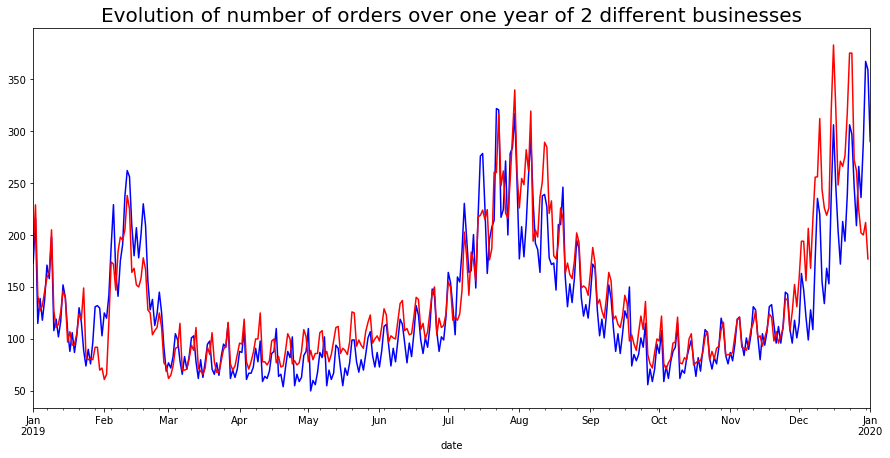

In [32]:
plt.figure(figsize=(15, 7))
tables[first_table][0]['updated_orders'].plot(color='blue')
tables[second_table][0]['updated_orders'].plot(color='red')

plt.title("Evolution of number of orders over one year of 2 different businesses", fontsize=20)